In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

SET UP A BASIC LSTM MODEL 
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [72]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_3

In [73]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     0  1995-01-03   1.228913   25967200
1     1  1995-01-04   1.260937   39670400
2     2  1995-01-05   1.244925   18410000
3     3  1995-01-06   1.344999  269155600
4     4  1995-01-09   1.319479   68521600
---
      Item        Date   Adj_Close    Volume
5147  5147  2015-06-12  122.781413  36886200
5148  5148  2015-06-15  122.540040  43988900
5149  5149  2015-06-16  123.196574  31494100
5150  5150  2015-06-17  122.906931  32918100
5151  5151  2015-06-18  123.466910  35407200


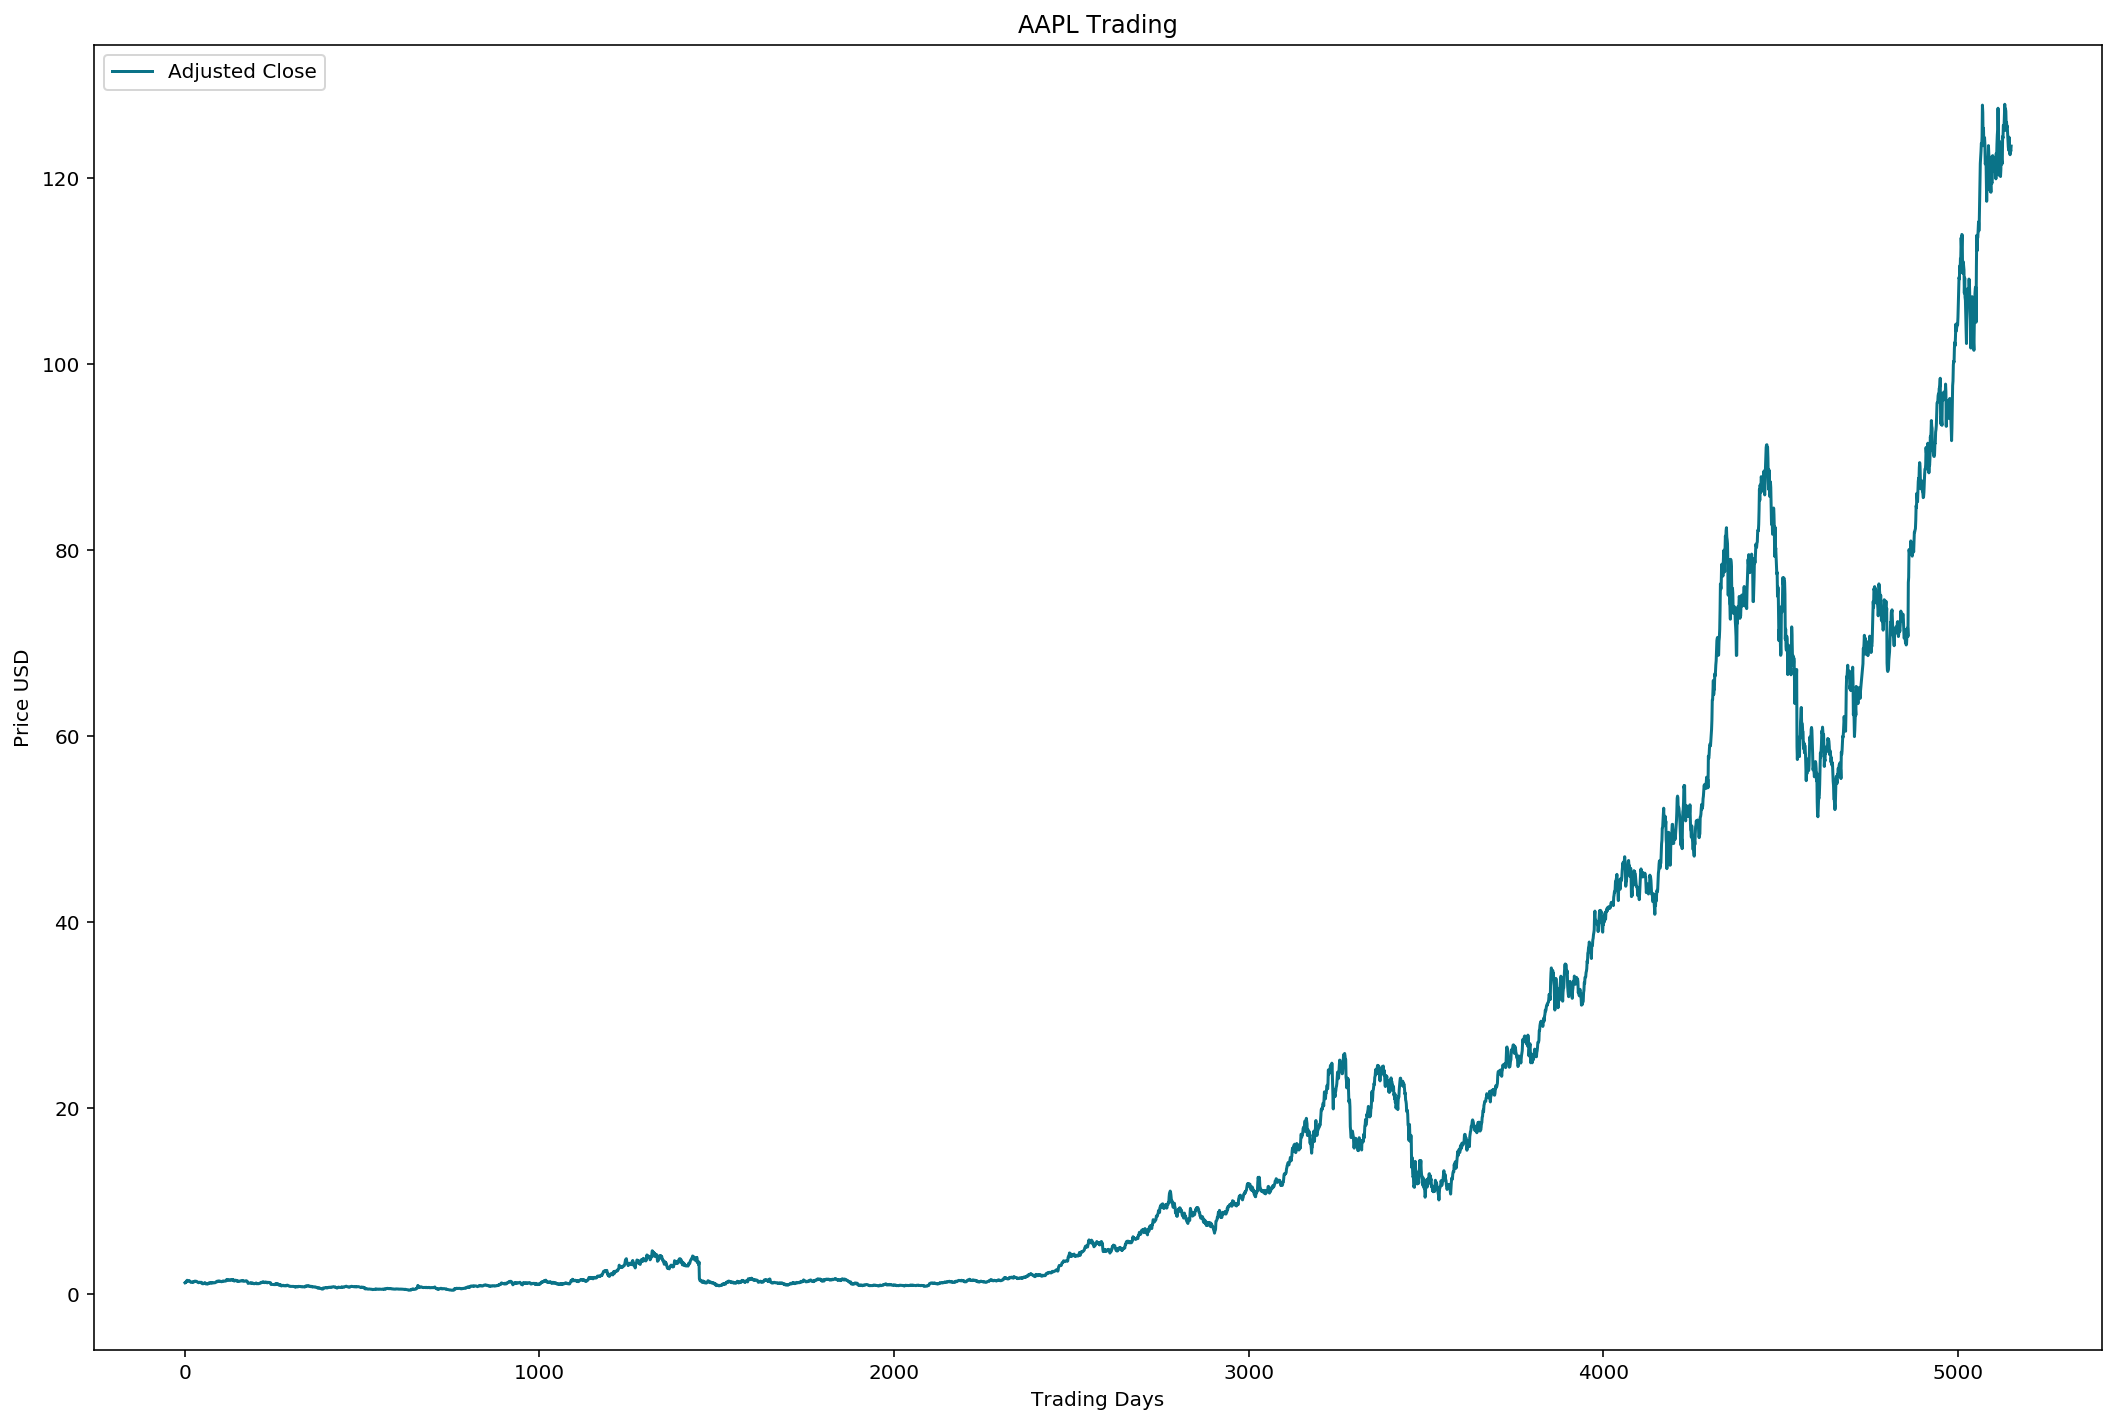

In [74]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Add title and legend
ax.set_title(base_ticker + ' Trading')
ax.legend(loc='upper left')

plt.show()

In [75]:
#Create numpy arrays for features and targets
X_day_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_day_all.append([(row['Item'])])
    close_all.append([(row['Adj_Close'])])

#pprint(X_day_all)
pprint(close_all)

[[1.228913],
 [1.260937],
 [1.244925],
 [1.344999],
 [1.319479],
 [1.399039],
 [1.497112],
 [1.45308],
 [1.437068],
 [1.425059],
 [1.441071],
 [1.461085],
 [1.469091],
 [1.365014],
 [1.353005],
 [1.33299],
 [1.312473],
 [1.26494],
 [1.276949],
 [1.2849549999999998],
 [1.292961],
 [1.2849549999999998],
 [1.33299],
 [1.296964],
 [1.296964],
 [1.3069709999999999],
 [1.355007],
 [1.397038],
 [1.401041],
 [1.404898],
 [1.378807],
 [1.366765],
 [1.386835],
 [1.364758],
 [1.31659],
 [1.310569],
 [1.290499],
 [1.252366],
 [1.2282819999999999],
 [1.268422],
 [1.284478],
 [1.284478],
 [1.292506],
 [1.27645],
 [1.230289],
 [1.270429],
 [1.27645],
 [1.268422],
 [1.2242680000000001],
 [1.1239190000000001],
 [1.1239190000000001],
 [1.131946],
 [1.127932],
 [1.131946],
 [1.164058],
 [1.222261],
 [1.192156],
 [1.212226],
 [1.1941629999999999],
 [1.103849],
 [1.103849],
 [1.13596],
 [1.131946],
 [1.139975],
 [1.087793],
 [1.115891],
 [1.1801139999999999],
 [1.1801139999999999],
 [1.1761],
 [1.212226],


In [76]:
# Reshape into t and t+1
look_back = 1 #50
tt_split = (1.0-.315)
#X_day_train_t, X_day_train_t1, X_day_test_t, X_day_test_t1 = create_dataset(X_day_all, look_back, tt_split, True)
#X_vol_train_t, X_vol_train_t1 = create_dataset(X_vol_train, look_back, True)
X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)

pprint(X_close_train)
print('--')
pprint(y_close_train)

array([[[ 0.00634957]],

       [[ 0.00660065]],

       [[ 0.00647511]],

       ..., 
       [[ 0.08341128]],

       [[ 0.08889649]],

       [[ 0.09278693]]])
--
array([[ 0.00660065],
       [ 0.00647511],
       [ 0.00725971],
       ..., 
       [ 0.08889649],
       [ 0.09278693],
       [ 0.09120231]])


In [77]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 1 # 200
n_nodes = [16]

# Create the LSTM model
model = Sequential()
model.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  1.63884902


In [78]:
# Train the model
model.fit(X_close_train, 
          y_close_train, 
          nb_epoch=epochs, 
          batch_size=batch_size, 
          verbose=2)


Epoch 1/1
10s - loss: 2.0083e-04


In [79]:
# Generate predictions for training
#testPredict = model.predict(X_close_test, batch_size=batch_size)
testPredict = util.predict_sequences(model, X_close_test)
pprint(testPredict)

[[0.090781204],
 [0.088721037],
 [0.090453118],
 [0.088280499],
 [0.086314388],
 [0.085342087],
 [0.082907841],
 [0.080915079],
 [0.079842702],
 [0.075628929],
 [0.080353305],
 [0.086007312],
 [0.086007312],
 [0.087317757],
 [0.08843419],
 [0.091991417],
 [0.090760708],
 [0.087819561],
 [0.089233369],
 [0.090740204],
 [0.091324709],
 [0.094310768],
 [0.097659856],
 [0.10052934],
 [0.095717706],
 [0.094680399],
 [0.097197302],
 [0.097084269],
 [0.092329942],
 [0.092165805],
 [0.088341966],
 [0.088915721],
 [0.084564529],
 [0.087942474],
 [0.088874735],
 [0.086856969],
 [0.086979829],
 [0.085577466],
 [0.086017534],
 [0.088884965],
 [0.08649864],
 [0.082877174],
 [0.080639265],
 [0.086283669],
 [0.090432614],
 [0.094197825],
 [0.093766674],
 [0.093243212],
 [0.09759818],
 [0.099510804],
 [0.099613681],
 [0.099582791],
 [0.10583381],
 [0.10463814],
 [0.10462786],
 [0.10811315],
 [0.10499886],
 [0.10256756],
 [0.10321639],
 [0.10689591],
 [0.11104495],
 [0.11443466],
 [0.11697954],
 [0.113

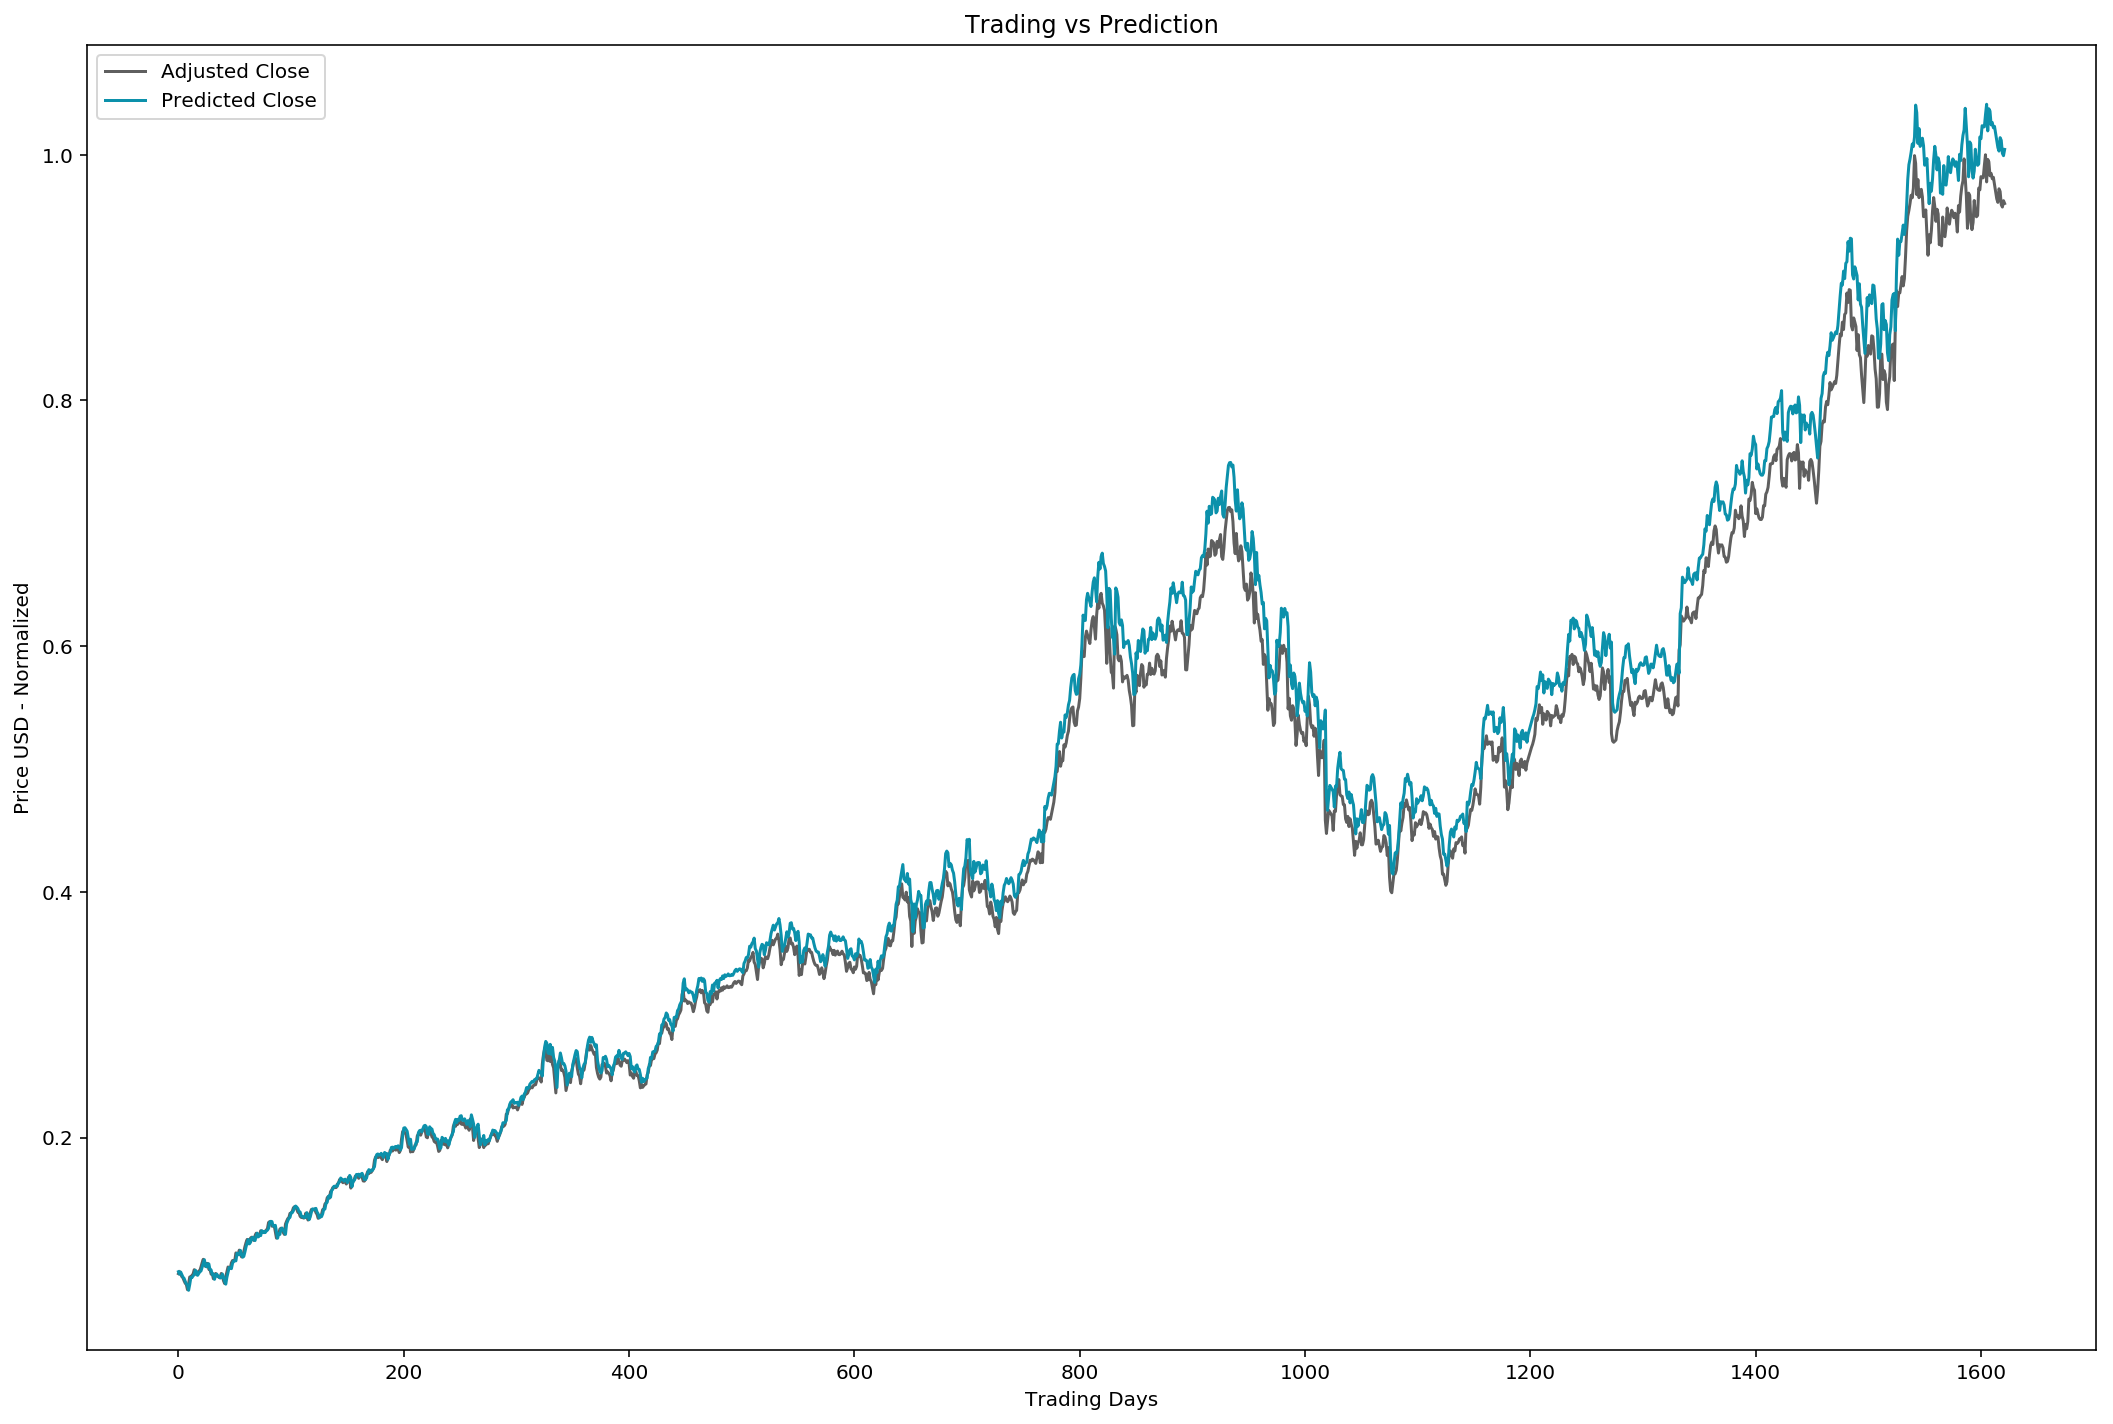

In [80]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [81]:
# The mean squared error
testScore = model.evaluate(X_close_test, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.00059 MSE (0.02429 RMSE)


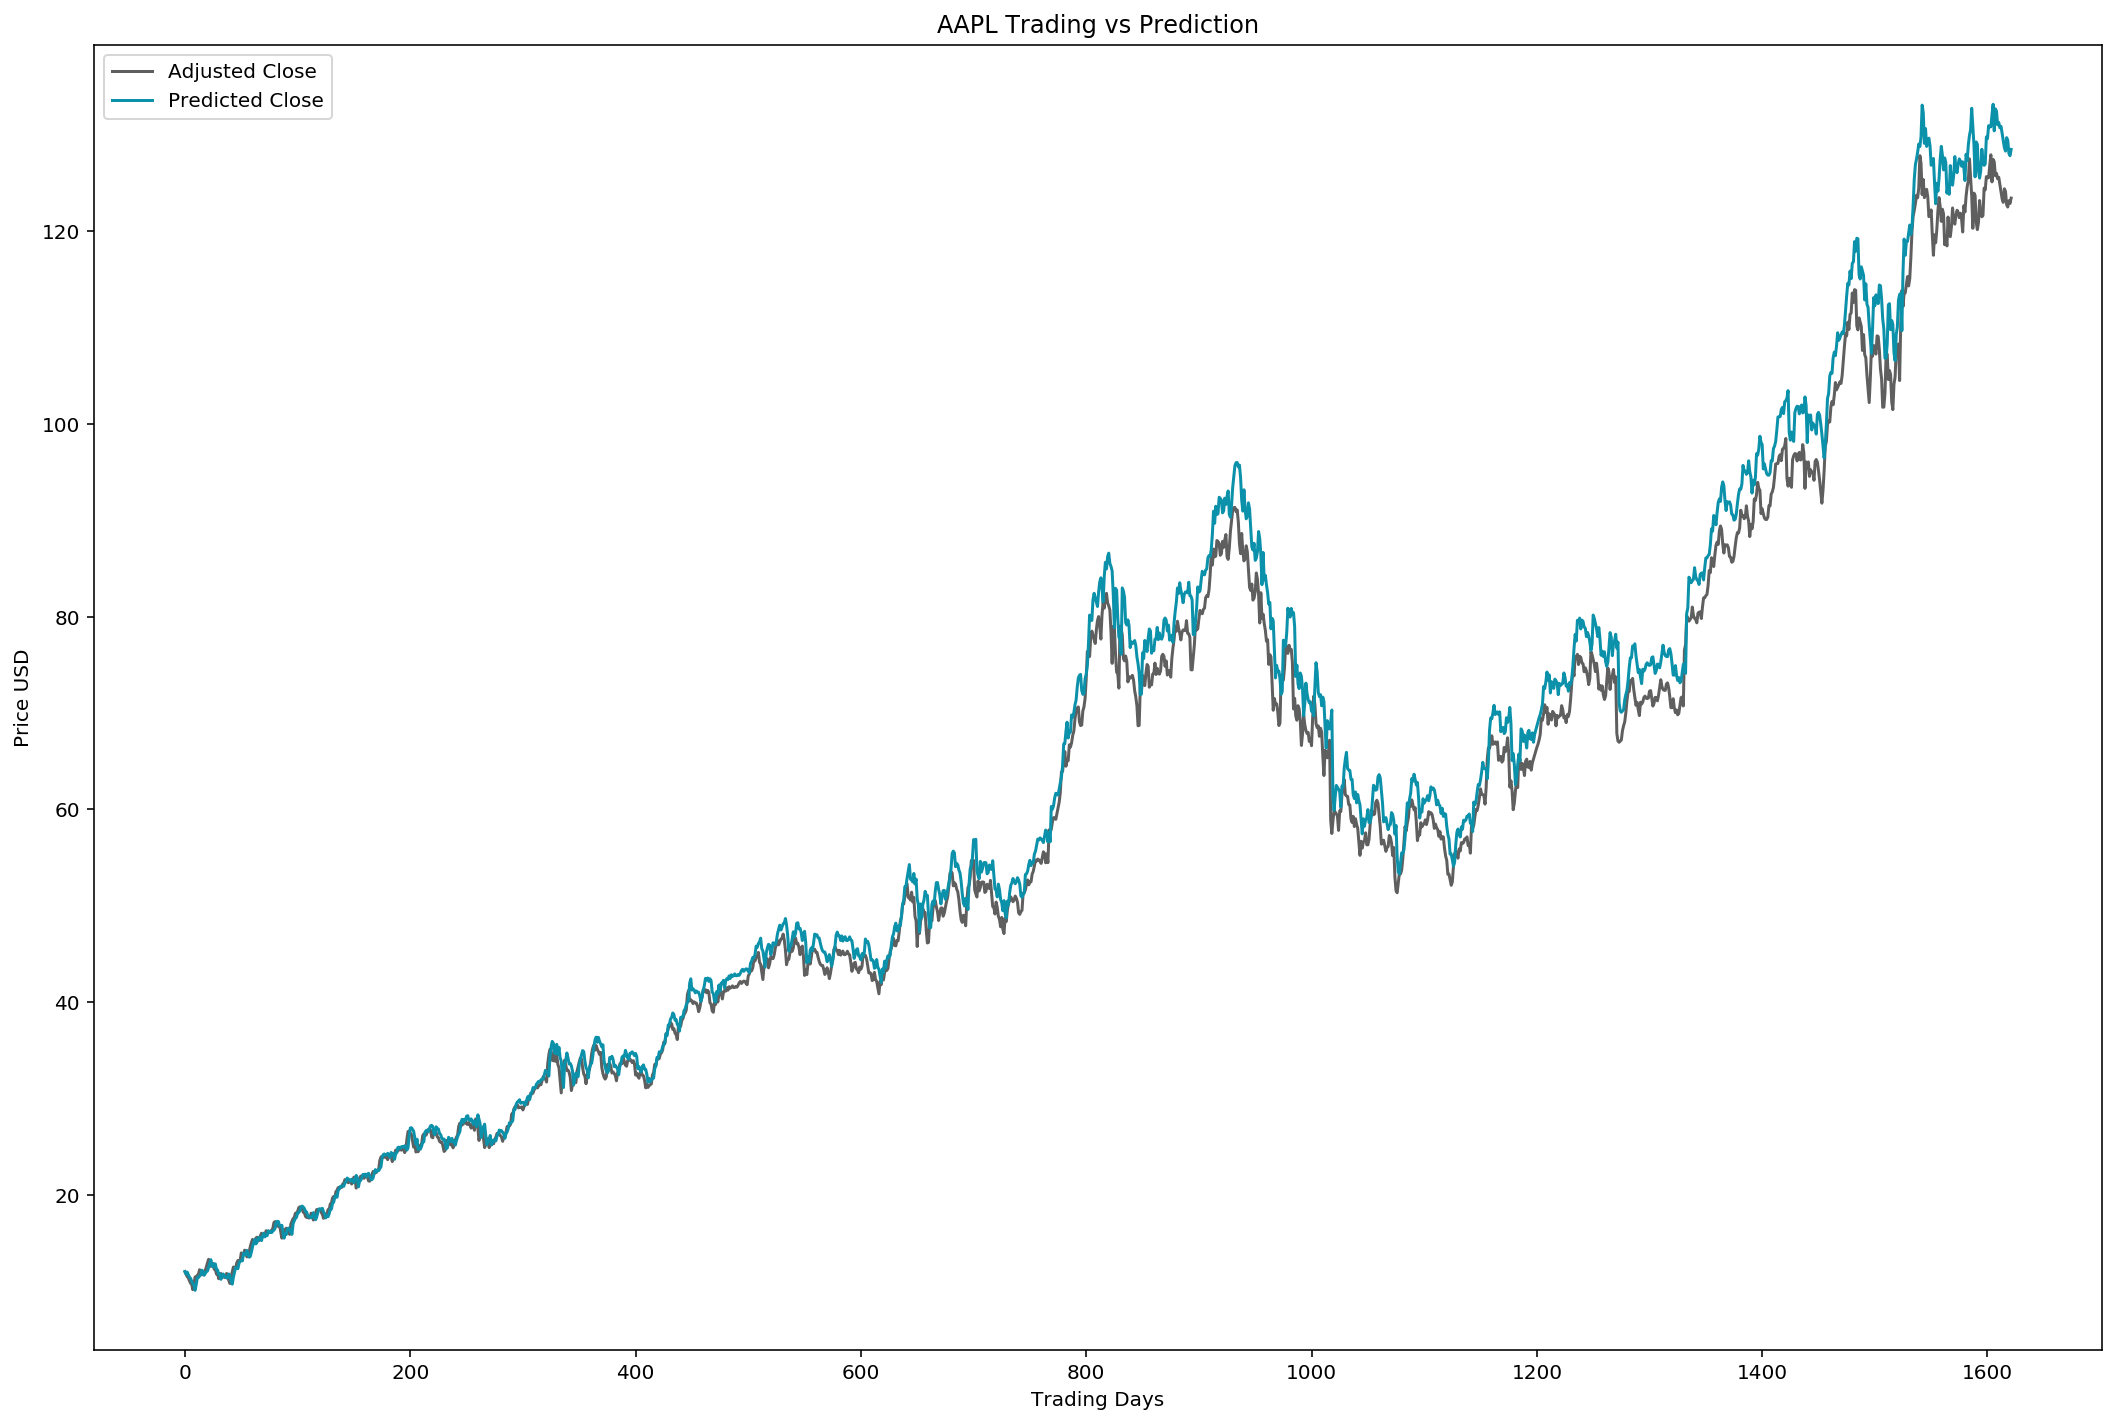

In [82]:
# Plot the predictions
close_plot = close_all[-y_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')


# Log of Results:

### SPY
Epochs: 1 Lookback: 1 NumNodes: 8 Test Score: 0.00008 MSE (0.00890 RMSE)

Epochs: 1 Lookback: 1 NumNodes: 16 Test Score: 0.00006 MSE (0.00750 RMSE)

Epochs: 1 Lookback: 1 NumNodes: 32 Test Score: 0.00023 MSE (0.01505 RMSE)

Epochs: 1 Lookback: 1 NumNodes: 64 Test Score: 0.00015 MSE (0.01236 RMSE)

Epochs: 1 Lookback: 1 NumNodes: 128 Test Score: 0.00008 MSE (0.00889 RMSE)

### GE
Epochs: 1 Lookback: 1 NumNodes: 16 Test Score: 0.00009 MSE (0.00942 RMSE)

### MSFT
Epochs: 1 Lookback: 1 NumNodes: 16 Test Score: 0.00010 MSE (0.01022 RMSE)

### AAPL
Epochs: 1 Lookback: 1 NumNodes: 16 Test Score: 0.00059 MSE (0.02429 RMSE)